In [3]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pymc
import pymc as pm
import pytensor
import pytensor.tensor as pt
#import pymc.sampling_jax
#import numpyro
# import blackjax
# import jax
import arviz as az

# sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV


#statsmodels
import statsmodels.graphics.tsaplots as smg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import kpss


# warnings
import warnings
warnings.filterwarnings("ignore")


# plots
settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5,
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)



### Plot helpers

In [4]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

### Data

(74, 38)
           Startups  Startups_1_person  Startups_2_10_person  \
1/1/2006        NaN                NaN                   NaN   
4/1/2006        NaN                NaN                   NaN   
7/1/2006        NaN                NaN                   NaN   
10/1/2007       NaN                NaN                   NaN   
1/1/2007    46865.0            38495.0                7735.0   
...             ...                ...                   ...   
4/1/2023    66970.0            61840.0                4990.0   
7/1/2023    64570.0            59570.0                4910.0   
10/1/2023   61245.0            56735.0                4435.0   
1/1/2024    57750.0            53635.0                4015.0   
4/1/2024    60065.0            55080.0                4835.0   

           Startups_10_50_person  Startups_50_250_person  \
1/1/2006                     NaN                     NaN   
4/1/2006                     NaN                     NaN   
7/1/2006                     NaN          

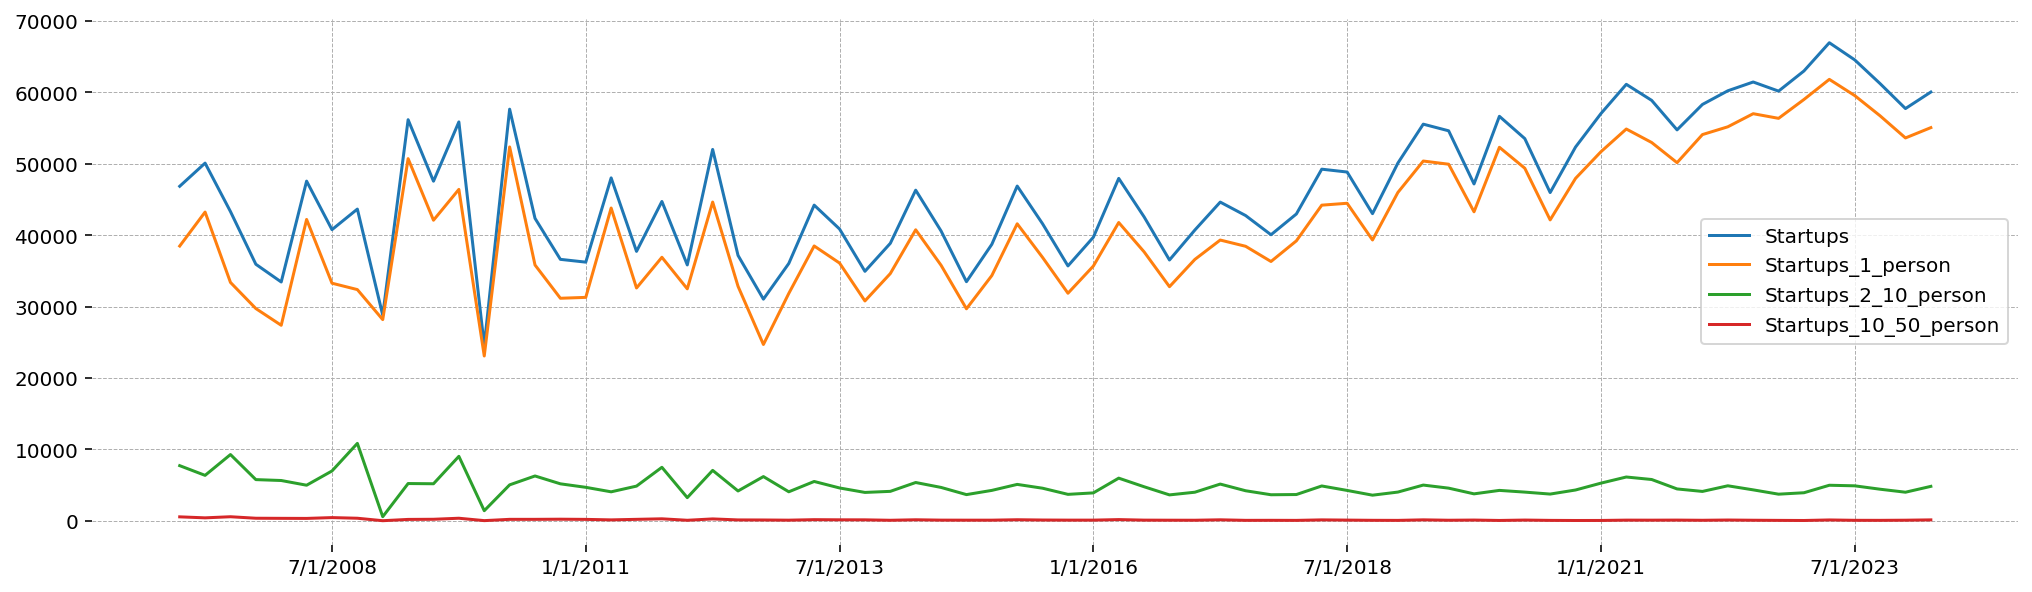

In [5]:
def readdata():
    data = pd.read_csv(r'../data/startups.csv', index_col=[0], date_format="mm/dd/yyyy")
    data.rename(columns = {'All Economic Activities, Total Business Start-Ups': 'Startups',
                        'All Economic Activities, 1 Employed Person or Less': 'Startups_1_person',
                        'All Economic Activities, 2 to 10 Employed Persons': 'Startups_2_10_person',
                        'All Economic Activities, 10 to 50 Employed Persons': 'Startups_10_50_person',
                        'All Economic Activities, 50 to 250 Employed Persons': 'Startups_50_250_person',
    }, inplace = True)
    data.columns
    data.drop(columns=['All Economic Activities, 250 Employees or More'], inplace=True)
    data.iloc[:,0:4].plot()
    print(data.shape)

    return data

raw_data = readdata()
print(raw_data)
print(raw_data.info())


In [6]:
print(raw_data.isnull().sum())

Startups                                                                                                                                                                                                                                                                                                                                                       4
Startups_1_person                                                                                                                                                                                                                                                                                                                                              4
Startups_2_10_person                                                                                                                                                                                                                                                                                  

In [7]:
def prepare_data(data):

    # stationary
    dontDifference = []
    data_diff = data.diff(4)
    data_diff.corr().to_csv('../output/data_diff_4_corr.csv')

    #too few observations
    data_diff.drop(columns=["Startups_1_person", 
                            "Startups_2_10_person", 
                            "Startups_10_50_person", 
                            "Startups_50_250_person", 
                            #"Netherlands, GDP [thousands]", # so, don't drop
                            "Netherlands, Wages & Salaries, Wages, Hourly, Total, Incl. Bonus, Index", 
                            "Netherlands, Producer Price Index, C Manufactured Products, Index",
                            "Netherlands, Gross Domestic Product, Total, Total, Current Prices, SA, EUR [billions]",
                            "Netherlands, Gross Domestic Product, Total, Total, Constant Prices, SA, EUR [billions]",
                            #"Netherlands, Nominal GDP [thousands]",
                            #"Netherlands, GDP [thousands]",
                            "Netherlands, OECD QNA, Gross Domestic Product, Gross Domestic Product - Expenditure Approach, Final Consumption Expenditure, Private Final Consumption Expenditure, Total, OECD Reference Year, Constant Prices, SA, AR, EUR [billions]",
                            "Netherlands, Eurostat, Job Vacancy, Job Vacancy Rate, Total, Business Economy (B-N), SA",
                            "Natural Gas, Dutch TTF Natural Gas (TTFI), Index, EUR",
                            "Netherlands, OECD MEI, Producer Prices Index, Economic Activities, Manufacturing, Total, Index",
                            "Netherlands, BIS Credit to Non-Financial Sectors, From All Sectors To Non Financial Sector, Market Value, Adjusted for Breaks, EUR [billions]"

                            ], inplace=True)


    
    
    data_diff.dropna(inplace=True)
    
    print(data_diff.shape)

    data_diff.to_csv("tmp.csv")


    return data_diff

data_diff = prepare_data(raw_data)
data_diff


(66, 25)


,Startups,"Netherlands, GDP [thousands]","Netherlands, Interbank Rates, EURIBOR, 1 Month, Fixing","Netherlands, Three month money market rate","Netherlands, Policy Rates, ECB, Fixed Rate Tenders","Netherlands, Eurostat, HICP, All-Items HICP, 2015=100, Index","Netherlands, Employment","Netherlands, Monetary Statistics, Monetary Aggregates, M3, Total (incl. Currency in Circulation), EUR [billions]","Netherlands, Eurostat, Consumer Surveys, Eurostat, Consumer Confidence, Price Trends Over the Next 12 Months","Netherlands, Composite PMI, EUR",...,"Netherlands, Lending Surveys, Central Bank of Netherlands, Bank Lending Survey, Demand for Loans Past 3 Months, Enterprises, Total","Netherlands, Deposits & Loans, MFIs, Loans, By Entity, to Euro Area Residents, Private Sector, Non-Financial Private Corporations, Total, EUR [billions]","Netherlands, DG ECFIN AMECO, Population & Employment, Unemployment, NAWRU, Estimate","Netherlands, Nominal GDP [thousands]","Netherlands, Government Benchmarks, Macrobond, 5 Year, Yield","Euro Area, Swap Rates, Macrobond, EUR, 5 Year, Mid","Euro Area 19, Long term interest rate","Netherlands, ECB, Interest Rates, MFI Interest Rates, Non-Financial Corporations, Loans (Cost Borrowing Indicator, Sum of A2A & A2Z (Non-Financial Corporations)), Annualised Agreed Rate (AAR) / Narrowly Defined Effective Rate (NDER), Total Calculated by Weighting the Volumes with a Moving Average, Total, New Business, Currency Denominator: Euro","Netherlands, Income Approach, Total Economy, Operating Surplus, Net, Current Prices, SA, EUR [billions]","World, Crude Oil, Brent, Spot, FOB North Sea, ICE, Close, USD"
1/1/2008,-13405.0,7.0,0.5,0.7,0.0,1.0,221.0,15.0,16.0,-5.0,...,0.0,44.8,0.0,9.0,-0.3,-0.1,0.0,0.5,2.0,38.0
4/1/2008,-2525.0,6.0,0.4,0.8,0.0,2.0,201.0,41.0,10.0,-6.0,...,-40.0,54.5,0.0,9.0,-0.1,0.1,0.0,0.4,0.0,53.0
7/1/2008,-2535.0,4.0,0.2,0.5,0.0,3.0,175.0,21.0,2.0,-7.0,...,-40.0,55.9,0.0,7.0,0.0,0.2,0.1,0.3,0.0,44.0
10/1/2008,7725.0,-2.0,-0.5,-0.5,-1.0,2.0,168.0,26.0,-25.0,-12.0,...,90.0,42.3,0.0,4.0,-0.8,-0.7,-0.4,-0.3,0.0,-30.0
1/1/2009,-4650.0,-7.0,-2.5,-2.5,-2.0,2.0,132.0,47.0,-49.0,-15.0,...,-80.0,21.2,0.0,-3.0,-0.8,-1.2,-0.4,-1.8,-4.0,-51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4/1/2023,6730.0,-2.0,3.7,3.8,4.0,7.0,186.0,19.0,-39.0,-10.0,...,-100.0,-2.6,0.0,19.0,1.6,1.5,1.3,2.7,6.0,-33.0
7/1/2023,3100.0,-3.0,3.5,3.3,3.0,3.0,183.0,-23.0,-32.0,-5.0,...,-50.0,-9.5,0.0,17.0,1.6,1.3,1.1,2.6,4.0,-11.0
10/1/2023,1050.0,-1.0,2.5,2.2,3.0,0.0,132.0,-30.0,-14.0,-3.0,...,-33.0,-0.2,0.0,15.0,0.5,0.1,0.3,1.9,3.0,-5.0
1/1/2024,-5265.0,-2.0,1.5,1.3,2.0,4.0,99.0,-24.0,4.0,1.0,...,33.0,7.9,0.0,15.0,-0.1,-0.3,-0.2,1.0,0.0,0.0


### Stationarity

In [8]:
def kpss_test(timeseries, colname):
   
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    
    pval = kpss_output.values[1]
    if pval <= 0.05:
        print(colname, " is N=not Stationary")

    return None

for i in np.arange(0, data_diff.shape[1]):
    data = data_diff.iloc[:,i]
    col1 = data_diff.columns[i]   
    kpss_test(data.values, col1)

Netherlands, Interbank Rates, EURIBOR, 1 Month, Fixing  is N=not Stationary
Netherlands, Three month money market rate  is N=not Stationary
Netherlands, Policy Rates, ECB, Fixed Rate Tenders  is N=not Stationary
Netherlands, Employment  is N=not Stationary
Netherlands, Deposits & Loans, MFIs, Loans, By Entity, to Euro Area Residents, Private Sector, Non-Financial Private Corporations, Total, EUR [billions]  is N=not Stationary
Netherlands, Nominal GDP [thousands]  is N=not Stationary
Netherlands, Government Benchmarks, Macrobond, 5 Year, Yield  is N=not Stationary
Euro Area, Swap Rates, Macrobond, EUR, 5 Year, Mid  is N=not Stationary
Netherlands, ECB, Interest Rates, MFI Interest Rates, Non-Financial Corporations, Loans (Cost Borrowing Indicator, Sum of A2A & A2Z (Non-Financial Corporations)), Annualised Agreed Rate (AAR) / Narrowly Defined Effective Rate (NDER), Total Calculated by Weighting the Volumes with a Moving Average, Total, New Business, Currency Denominator: Euro  is N=not 

### Variance Inflation Factor (VIF)

In [9]:

def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
        for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs


In [10]:
y = data_diff.pop('Startups')
X = data_diff

# standardize
X = (X - X.mean())/X.std()
y = (y - y.mean())/y.std()

# vif neeeds constant
X = add_constant(X)
X = pd.DataFrame(X)


In [11]:
# run vif
vif = variance_inflation_factors(X)
vif = vif.to_frame().sort_values(by="VIF", ascending=False)
vif.to_csv('../output/VIF.csv')

### Lasso, Ridge regressions

In [12]:
data_diff = prepare_data(raw_data)

(66, 25)


### Standardize

In [13]:
y = data_diff.pop('Startups')
X = data_diff.copy()

# standardize
X = (X - X.mean())/X.std()
y = (y - y.mean())/y.std()


In [14]:
reg = Lasso(alpha=.04, fit_intercept=True)
reg.fit(X, y)


Lasso(alpha=0.04)

In [15]:
print('R squared training set', round(reg.score(X, y)*100, 2))

R squared training set 33.87


In [16]:
# Training data
pred = reg.predict(X)
mse = metrics.root_mean_squared_error(y, pred)
print('RMSE training set', round(mse, 2))

RMSE training set 0.81


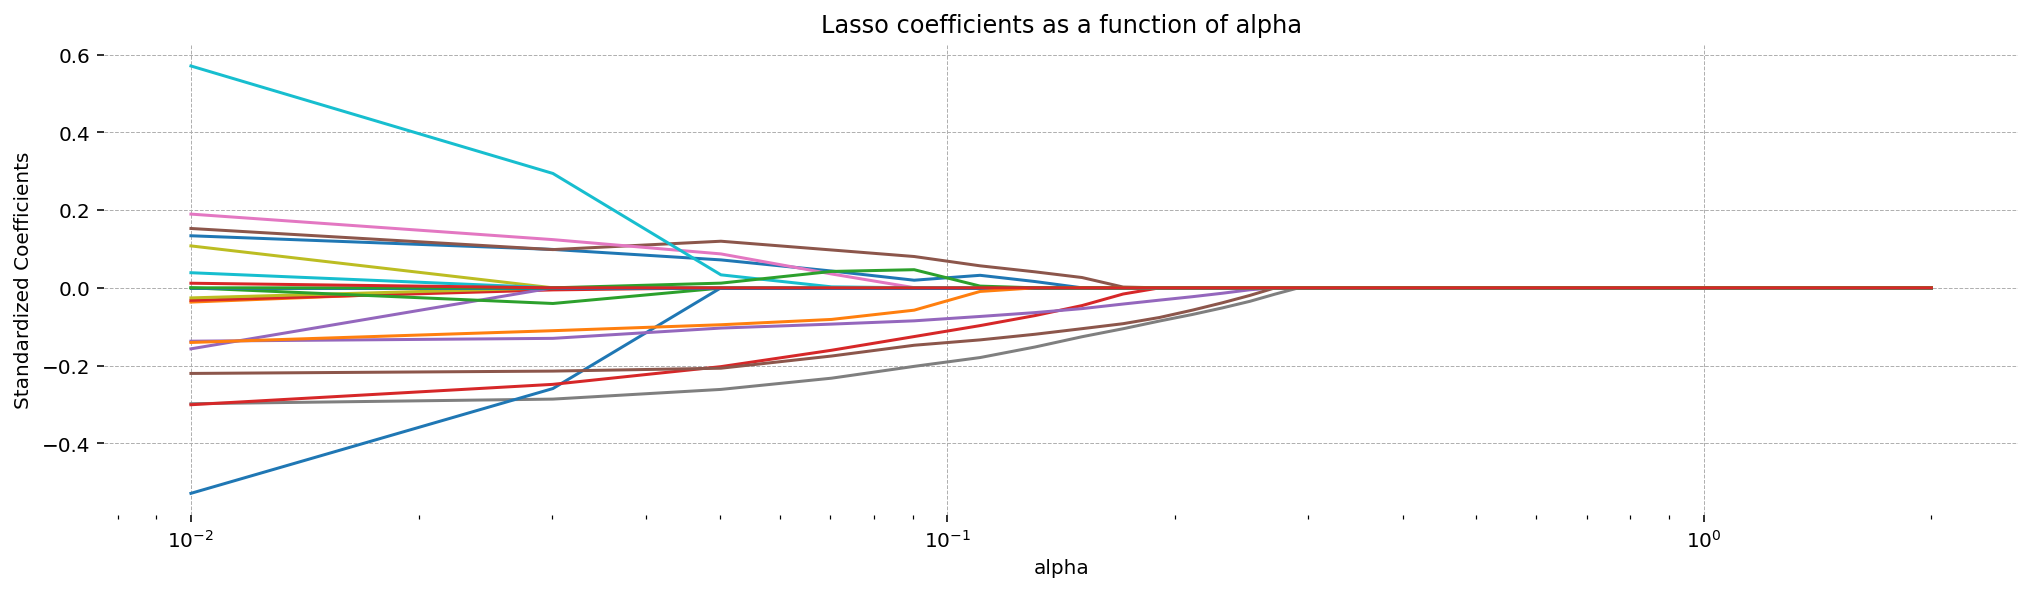

In [17]:
alphas = np.linspace(0.01,2,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [18]:
# Set best alpha
#lasso_best = Lasso(alpha=model.alpha_)
lasso_best = Lasso(alpha=.05)
lasso_best.fit(X, y)

Lasso(alpha=0.05)

In [19]:
df1 = pd.DataFrame(list(zip(lasso_best.coef_, X)))
lasso = df1.sort_values([0], ascending=False)

lasso.to_csv("../output/Lasso.csv")


data_diff.corr().to_csv(r'../output/data_diff_sub_corr.csv')

### Now with Hugos data

In [20]:
def readdata():
    data = pd.read_csv(r'../data/hugo_data.csv', index_col=[0], date_format="mm/dd/yyyy")
    return data


raw_data = readdata()

# drop Credit, doesn't appear in Lasso best, and gain a observation as a result of a missing value
raw_data.drop(columns=['Credit'], inplace=True)

print(raw_data)
print(raw_data.info())

           Start-ups      GDP         U     NAIRU  Job_vacancy        HICP  \
1/1/2006         NaN  179.989  6.433333  4.869898          NaN   86.326667   
4/1/2006         NaN  182.917  6.133333  4.877819          NaN   87.216667   
7/1/2006         NaN  183.853  5.933333  4.885739          NaN   87.123333   
10/1/2006        NaN  185.449  5.866667  4.893660          NaN   87.276667   
1/1/2007     46865.0  187.544  5.633333  4.936292          NaN   87.610000   
...              ...      ...       ...       ...          ...         ...   
4/1/2023     66970.0  234.334  3.466667  4.036260          5.0  128.120000   
7/1/2023     64570.0  233.457  3.633333  3.957463          4.8  129.320000   
10/1/2023    61245.0  234.031  3.566667  3.878666          4.7  128.356667   
1/1/2024     57750.0  233.302  3.633333  3.799049          4.6  129.153333   
4/1/2024     60065.0  235.674  3.633333  3.719431          4.6  131.796667   

           Cao-wages per hour  Borrowing_costs  Credit_standard

### Process data, difference and lags

In [21]:
raw_data.columns

#### Levels
# difference in order to make stationary
diff_data = raw_data.copy()
diff_data = diff_data.diff(4)
diff_data.columns = [x + "_diff" for x in diff_data.columns]
data1 = pd.concat([raw_data, diff_data])

# lag diff data
lag_diff_data = diff_data.copy()
lag_diff_data = lag_diff_data.shift(1)
lag_diff_data.columns = [x + "_lag" for x in lag_diff_data.columns]
data2 = pd.concat([diff_data, lag_diff_data], ignore_index=False, axis=1)
data2.to_csv("tmp.csv")

data2.index = raw_data.index
data2.drop(columns=['Start-ups_diff_lag'], inplace=True)

#### Percentage Change
reduced_raw_data = raw_data.drop(columns=['Credit_standard', 'Confidence'])

# percentage change
prct_data = reduced_raw_data.copy()
prct_data = np.log(prct_data).diff(4)
prct_data.columns = [x + "_prct" for x in reduced_raw_data.columns]

# lag percentage data
lag_prct_data = prct_data.copy()
lag_prct_data = lag_prct_data.shift(1)
lag_prct_data.columns = [x + "_lag" for x in lag_prct_data.columns]

data3 = pd.concat([prct_data, lag_prct_data], ignore_index=False, axis=1)
data3.to_csv("tmp.csv")
percentage_data = data3.copy() # for figures only

data3

,Start-ups_prct,GDP_prct,U_prct,NAIRU_prct,Job_vacancy_prct,HICP_prct,Cao-wages per hour_prct,Borrowing_costs_prct,Loans_prct,M3_prct,...,NAIRU_prct_lag,Job_vacancy_prct_lag,HICP_prct_lag,Cao-wages per hour_prct_lag,Borrowing_costs_prct_lag,Loans_prct_lag,M3_prct_lag,GDP_nom_prct_lag,Zelfstandigenaftrek_prct_lag,PMI_prct_lag
1/1/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4/1/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7/1/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/1/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/1/2007,NaN,0.041118,-0.132791,0.013541,NaN,0.014757,0.017002,0.194256,0.216171,0.124868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4/1/2023,0.105908,-0.004980,0.049271,-0.083871,-0.113329,0.061318,0.055656,1.205726,-0.007079,0.016618,...,-0.086566,-0.113329,0.069887,0.053595,1.211453,0.037108,0.047356,0.089653,-0.226716,-0.153362
7/1/2023,0.049201,-0.009006,-0.027151,-0.081061,-0.099091,0.027146,0.060680,0.978722,-0.026363,-0.019999,...,-0.083871,-0.113329,0.061318,0.055656,1.205726,-0.007079,0.016618,0.077036,-0.226716,-0.196367
10/1/2023,0.017293,-0.005680,-0.009302,-0.078129,-0.101096,0.004425,0.065771,0.553779,-0.000536,-0.026622,...,-0.081061,-0.099091,0.027146,0.060680,0.978722,-0.026363,-0.019999,0.065894,-0.226716,-0.105306
1/1/2024,-0.087249,-0.006979,0.027909,-0.079902,-0.083382,0.029252,0.064899,0.273868,0.021654,-0.021109,...,-0.078129,-0.101096,0.004425,0.065771,0.553779,-0.000536,-0.026622,0.055532,-0.226716,-0.045676


In [22]:
data2.dropna(inplace=True)

y = data2.pop('Start-ups_diff')
X = data2.copy()

# standardize

#if percent no reason to standardize
X = (X - X.mean())/X.std()
y = (y - y.mean())/y.std()



In [23]:
# run vif
vif = variance_inflation_factors(X)
vif = vif.to_frame().sort_values(by="VIF", ascending=False)
vif.to_csv('../output/VIF_diff.csv')

In [24]:

traintest = 58

X_train = X.iloc[:traintest,:]
X_test = X.iloc[traintest:,:]

y_train = y.iloc[:traintest]
y_test = y.iloc[traintest:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(58, 28) (3, 28) (58,) (3,)


In [25]:
reg = Lasso(alpha=0.001, fit_intercept=True)
reg.fit(X_train, y_train)
print('R squared training set', round(reg.score(X_train, y_train), 2))

R squared training set 0.74


In [26]:
# Training data
pred = reg.predict(X_train)
mse = metrics.root_mean_squared_error(y_train, pred)
print('RMSE training set', round(mse, 2))

RMSE training set 0.5


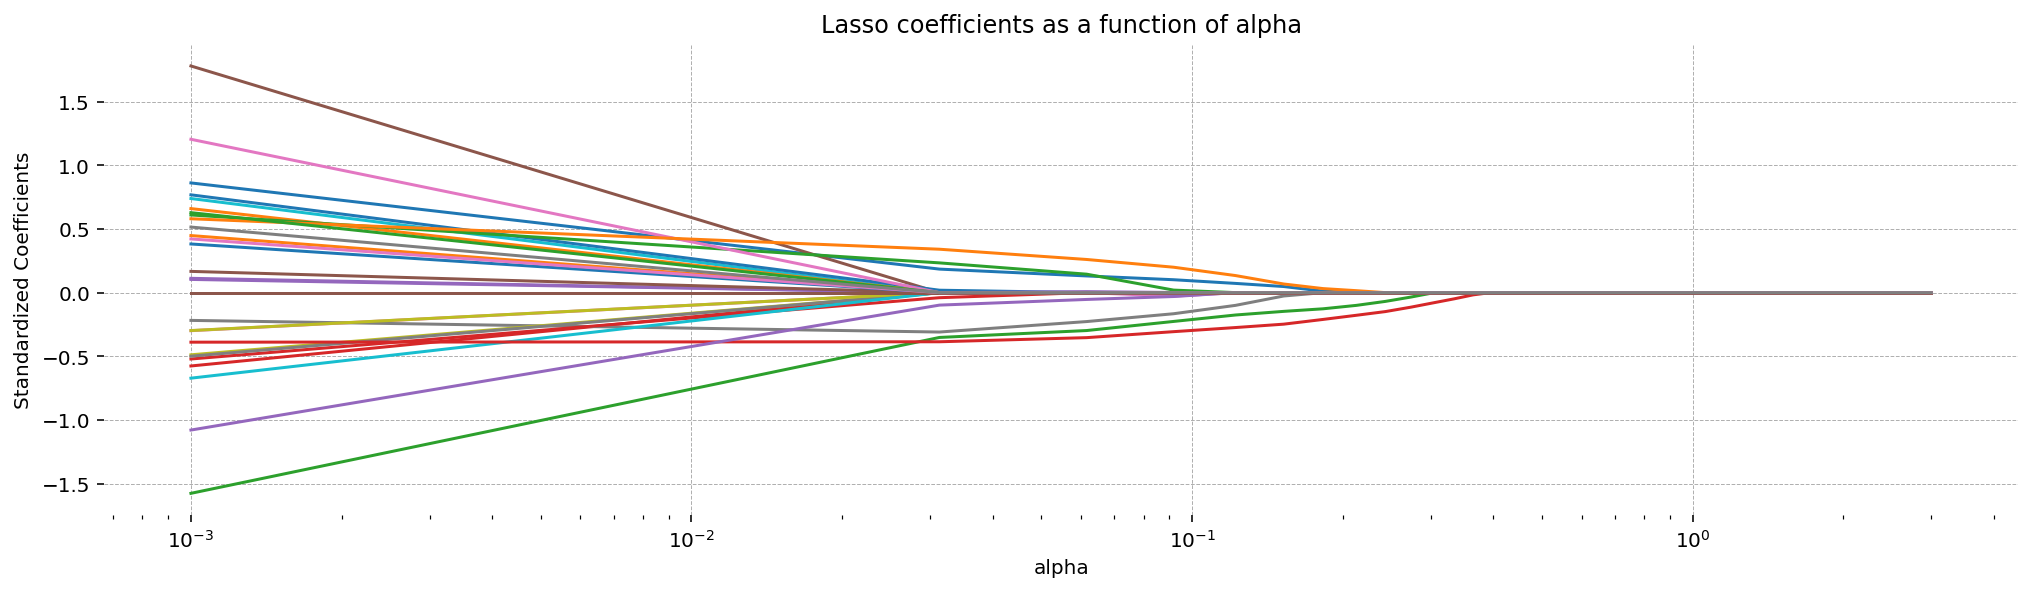

In [27]:
alphas = np.linspace(0.001,3,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [28]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
#lasso_best = Lasso(alpha=0.001)
lasso_best.fit(X_train, y_train)

NameError: name 'model' is not defined

In [118]:
df1 = pd.DataFrame(list(zip(lasso_best.coef_, X_train)))
lasso = df1.sort_values([0], ascending=False)
lasso.to_csv("../output/Lasso.csv")

In [119]:
reg = Lasso(alpha=0.001, fit_intercept=True)
reg.fit(X_train, y_train)
print('R squared training set', round(reg.score(X_train, y_train), 2))

R squared training set 0.74


In [120]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)
model.alpha_

0.05801578483184879

In [121]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.05801578483184879)

In [122]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 45.71
R squared test set -216.52


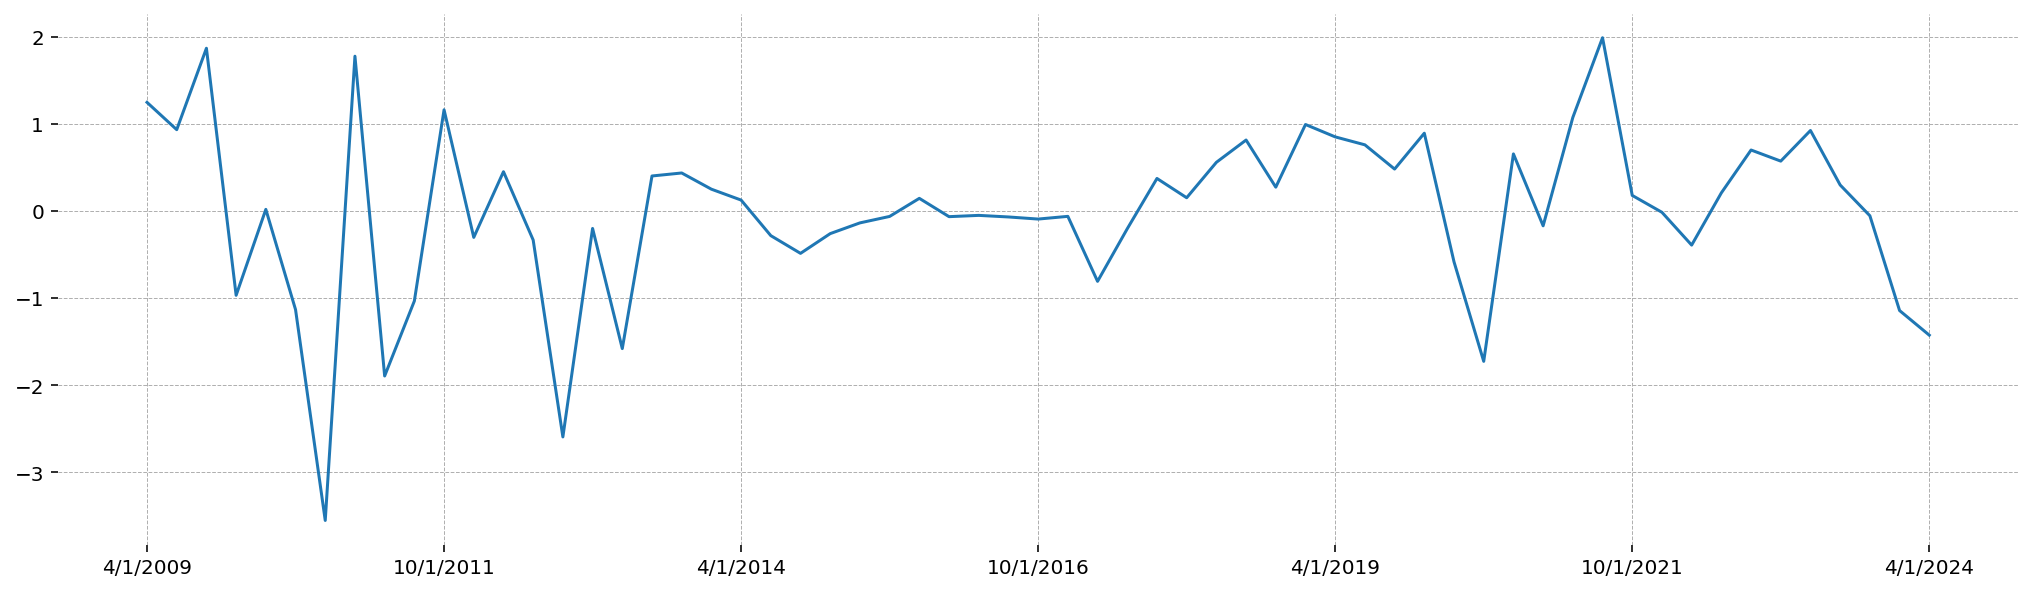

In [32]:
y.plot()
plt.savefig("../output/StartupsDifferenceStandardized.png")

#### Stationary?

In [124]:
for i in np.arange(0, data_diff.shape[1]):
    data = data_diff.iloc[:,i]
    col1 = data_diff.columns[i]   
    kpss_test(data.values, col1)

Netherlands, Interbank Rates, EURIBOR, 1 Month, Fixing  is N=not Stationary
Netherlands, Three month money market rate  is N=not Stationary
Netherlands, Policy Rates, ECB, Fixed Rate Tenders  is N=not Stationary
Netherlands, Employment  is N=not Stationary
Netherlands, Deposits & Loans, MFIs, Loans, By Entity, to Euro Area Residents, Private Sector, Non-Financial Private Corporations, Total, EUR [billions]  is N=not Stationary
Netherlands, Nominal GDP [thousands]  is N=not Stationary
Netherlands, Government Benchmarks, Macrobond, 5 Year, Yield  is N=not Stationary
Euro Area, Swap Rates, Macrobond, EUR, 5 Year, Mid  is N=not Stationary
Netherlands, ECB, Interest Rates, MFI Interest Rates, Non-Financial Corporations, Loans (Cost Borrowing Indicator, Sum of A2A & A2Z (Non-Financial Corporations)), Annualised Agreed Rate (AAR) / Narrowly Defined Effective Rate (NDER), Total Calculated by Weighting the Volumes with a Moving Average, Total, New Business, Currency Denominator: Euro  is N=not 

<Axes: >

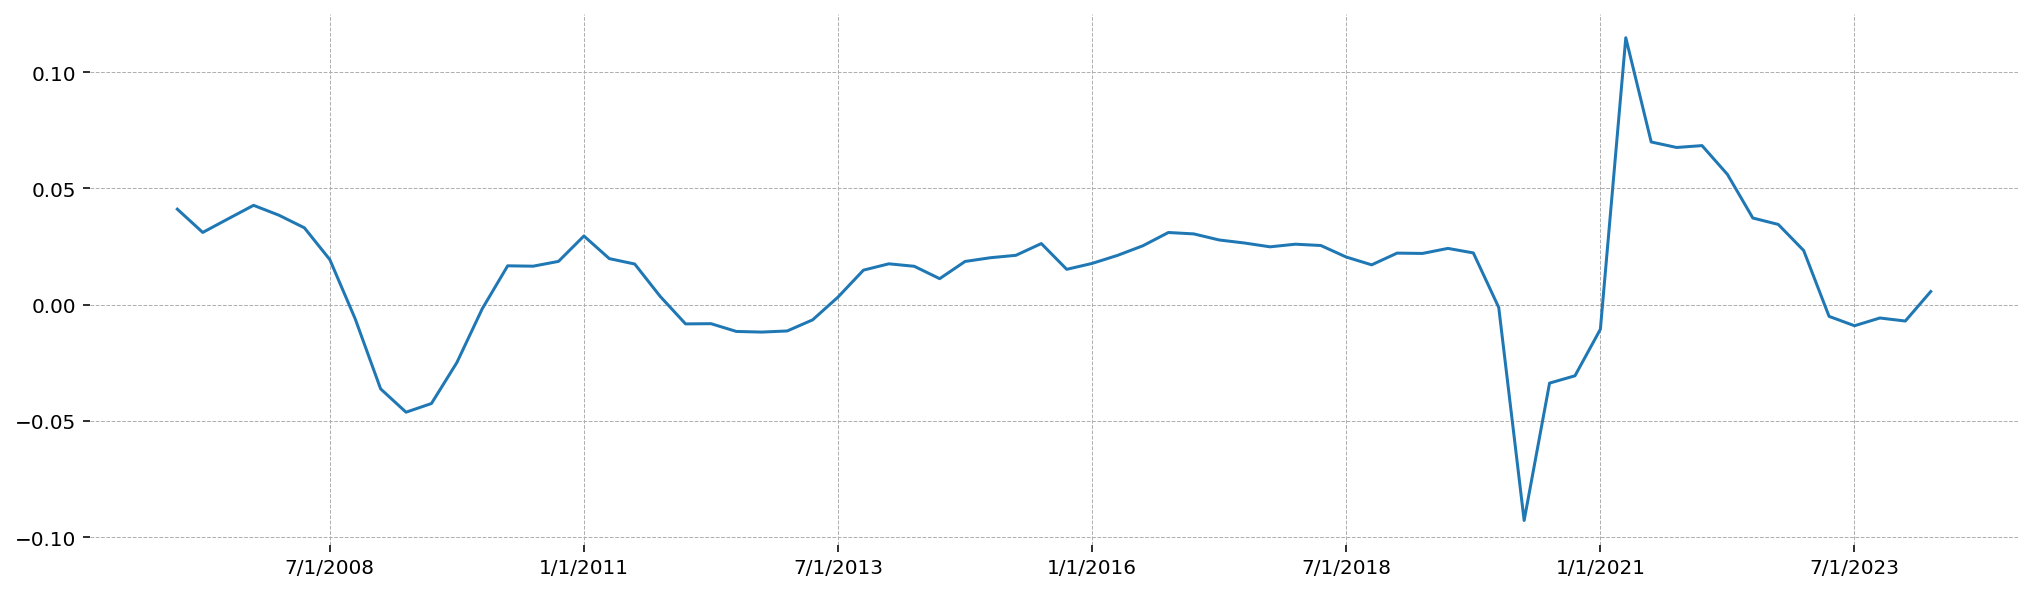

In [125]:
percentage_data['GDP_prct'].plot()